In [178]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [179]:
pip install captum

Note: you may need to restart the kernel to use updated packages.


In [180]:
import torch
import torchvision as t
import torchvision
import torchvision.transforms.functional as tvf
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
import os
from torch.utils.data import DataLoader
%matplotlib inline
import matplotlib.pyplot as plt
import random
import sys
import timm
import skimage.transform as skTrans
import scipy.io
from PIL import Image
import cv2
import numpy as np
from PIL import Image
from skimage.exposure import equalize_adapthist

In [181]:
from skimage import io
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchmetrics


class GlauDataset(Dataset):
    def __init__(self, is_train, transform=None):
        self.is_train = is_train
        self.transform = transform

        csv_file = '/kaggle/input/glaucoma/4000.csv'
        df = pd.read_csv(csv_file)
        ids = df['Eye ID'].tolist()
        labels = df['Final Label'].tolist()
        ids = [_.split('/')[-1] for _ in ids]

        pos_cases = []
        neg_cases = []
        for id, lab in zip(ids, labels):
            if lab == 1:
                pos_cases.append((id, lab))
            elif lab == 0:
                neg_cases.append((id, lab))

        num_pos_tr = int(len(pos_cases) * 0.8)
        num_neg_tr = int(len(neg_cases) * 0.8)
        self.train_data = pos_cases[:num_pos_tr] + neg_cases[:num_neg_tr]
        self.val_data = pos_cases[num_pos_tr:] + neg_cases[num_neg_tr:]

    def __len__(self):
        if self.is_train:
            return len(self.train_data)
        else:
            return len(self.val_data)

    def __getitem__(self, idx):
        if self.is_train:
            img_path, lab = self.train_data[idx]
            img = io.imread('/kaggle/input/claheprocessed/clahe_all/clahe_all/' + img_path)
            img = img.astype(np.float32)
            img = min_max_scale(img)
            img = img.transpose(2, 0, 1)
            img = torch.from_numpy(img)
            img = self.transform(img)
        else:
            img_path, lab = self.val_data[idx]
            img = io.imread('/kaggle/input/claheprocessed/clahe_all/clahe_all/' + img_path)
            img = img.astype(np.float32)
            img = img.transpose(2, 0, 1)
            img = torch.from_numpy(img)

        lab = torch.tensor(lab, dtype=torch.float32)
        return img, lab

def min_max_scale(img):
    min_val = img.min(axis=(0, 1))
    max_val = img.max(axis=(0, 1))
    img = (img - min_val)/(max_val-min_val+1e-8)
    return img

class ResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")
        self.model.fc = nn.Linear(2048, 1)

    def forward(self, x):
        return self.model(x).squeeze()

In [182]:
ckpt_path = '/kaggle/input/traing-model/clahe_model24.pt'
model = timm.create_model('efficientnet_b0',num_classes=2).cuda()
#checkpoint = torch.load(ckpt_path)

In [183]:
batch_size = 1
transform = transforms.Compose([
    transforms.Resize(256, antialias=True),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(degrees=45),
    # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    # transforms.CenterCrop(224),
    # transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset = GlauDataset(is_train=True, transform=transform)
val_dataset = GlauDataset(is_train=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


from skimage import io
INDEX = 0
csv_file = '/kaggle/input/glaucoma/4000.csv'
df = pd.read_csv(csv_file)
ids = df['Eye ID'].tolist()
labels = df['Final Label'].tolist()
ids = [_.split('/')[-1] for _ in ids]
image = io.imread('/kaggle/input/claheprocessed/clahe_all/clahe_all/'+ids[INDEX])
plt.imshow(np.fliplr(image))
model.eval()
print(f"GT: {labels[INDEX]}")
print(f"Pred: {preds_label}")

GT: 0.0
Pred: 0


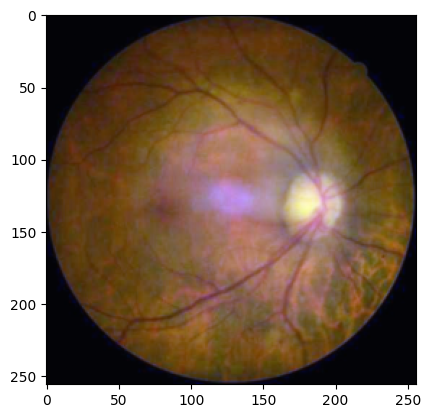

In [184]:
INDEX = 1600
image = train_dataset[INDEX][0]
plt.imshow(image.moveaxis(0,-1))
model.eval()
with torch.no_grad():
    x = image.unsqueeze(0).cuda()
    output = model(x)
    preds_prob = torch.nn.functional.softmax(output,dim=1)
    preds_label = torch.argmax(preds_prob,dim=1).item()
print(f"GT: {train_dataset[INDEX][1]}")
print(f"Pred: {preds_label}")

In [185]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
layer_gc = LayerGradCam(forward_func = model, layer = model.conv_head)
i = 0
for inputss, label in train_loader:
    if i == INDEX:
        inputss = inputss.to(device)
        attribution = layer_gc.attribute(inputs = inputss, 
                                     target = 1,
                                     attribute_to_layer_input=False,
                                     relu_attributions=True)
        upsampled_attr = LayerAttribution.interpolate(attribution, (256, 256),interpolate_mode='bilinear')
        break
    else: 
        i+=1

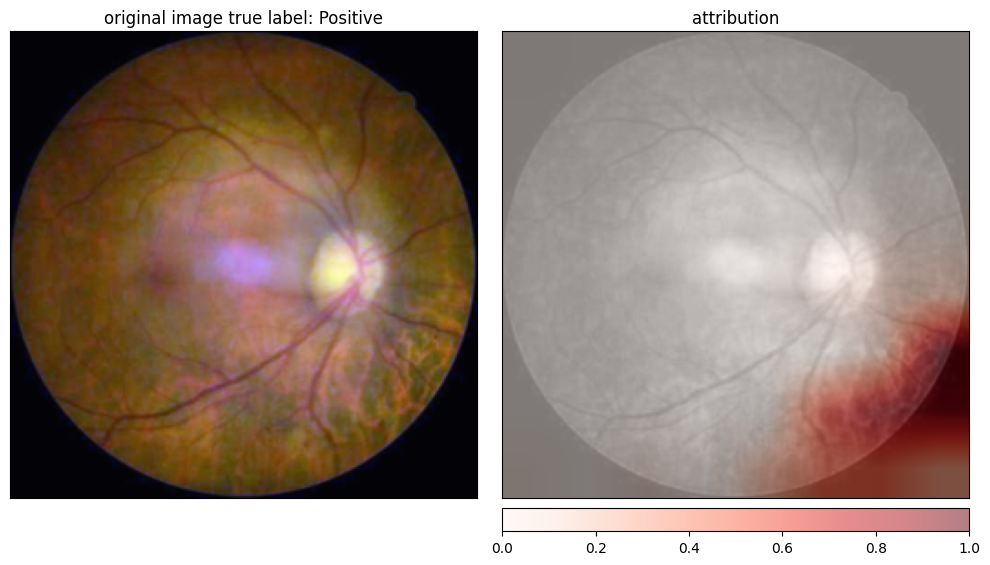

In [188]:
fig,ax=viz.visualize_image_attr_multiple(
                                   attr            = (np.transpose(upsampled_attr.squeeze(0).cpu().detach().numpy(),(1, 2, 0))),
                                   original_image  = np.transpose(x[0].cpu().detach().numpy(), (1, 2, 0)), # H,W,C
                                   methods         =  ["original_image", "blended_heat_map"],
                                   signs           =  ["all", "positive"],
                                   titles          = ['original image true label: Positive' , 
                                                        "attribution"
                                                     ],
                                   show_colorbar   = True,
                                   fig_size        = (10,10),
                                   cmap="Reds",
                                   use_pyplot = True
                                )